# Section II: Programming

## Part I: Cluster Validity (15 point)

In [66]:
## loading packages
from math import log
import numpy as np
from scipy import sparse as sp
from scipy.special import comb
from sklearn.utils import check_random_state
from scipy.special import comb
from sklearn.utils import check_X_y
# from sklearn.utils import _safe_indexing
# from sklearn.utils import pairwise_distances_chunked
# from sklearn.pairwise import pairwise_distances
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import deprecated

In [67]:
## getting contingency_matrix 
def contingency_matrix(labels_true, labels_pred):
    '''
    Contingency matrix reports the intersection cardinality for every true/predicted cluster pair. 
    The contingency matrix provides sufficient statistics for all clustering metrics where 
    the samples are independent and identically distributed and one doesn’t need to account for some
    instances not being clustered.
    '''
    """Build a contingency matrix describing the relationship between labels.
    Parameters
    ----------
    labels_true : int array, shape = [n_samples]
    labels_pred : array-like of shape [n_samples]
        Cluster labels to evaluate

    Returns
    -------
    contingency : {array-like, sparse}, shape=[n_classes_true, n_classes_pred]
        Matrix :math:`C` such that :math:`C_{i, j}` is the number of samples in
        true class :math:`i` and in predicted class :math:`j`. If
            """
    classes, class_idx = np.unique(labels_true, return_inverse=True)
    clusters, cluster_idx = np.unique(labels_pred, return_inverse=True)
    n_classes = classes.shape[0]
    n_clusters = clusters.shape[0]
    
    # Using coo_matrix to accelerate simple histogram calculation,
    # Currently, coo_matrix is faster than histogram2d for simple cases
    contingency = sp.coo_matrix((np.ones(class_idx.shape[0]),
                                 (class_idx, cluster_idx)),
                                shape=(n_classes, n_clusters),
                                dtype=np.int)
  
    contingency = contingency.toarray()
        
    return contingency

In [68]:
## testing
labels_true = np.array([[0,0,1,1,0,2,2]]).reshape(7,1)
labels_pred = np.array([[0,0,2,1,0,2,2]]).reshape(7,1)
contingency_matrix(labels_true,labels_pred)

array([[3, 0, 0],
       [0, 1, 1],
       [0, 0, 2]])

### Accuracry 

The accuracy is defined as the geometric mean of the pairwise precision and recall:
accuracy = TP/(TP+FP+TN+FN)

Where TP is the number of True Positive (i.e. the number of pair of points that belong to the same clusters in both the true labels and the predicted labels), FP is the number of False Positive (i.e. the number of pair of points that belong to the same clusters in the true labels and not in the predicted labels) and FN is the number of False Negative (i.e the number of pair of points that belongs in the same clusters in the predicted labels and not in the true labels).

The score ranges from 0 to 1. A high value indicates a good similarity between two clusters.

In [69]:
def accuracy(truth, prediction):
    # make sure that the shape of truth and prediction is the same
    assert truth.shape == prediction.shape
    
    ## find how many clusters it has
    num = len(np.unique(truth))
    
    ## find the total points
    total_num = len(truth)
    
    ## create a matrix for true and predicted clusters
    cluster_matrix = np.zeros([num,num])
    
    # True positive points
    TP = 0
    for i in range(num):
        count = 0
        for j in range(len(truth)):
            if truth[j]==prediction[j]==i:
                count += 1
        cluster_matrix[i,i]= count
        TP += count
    return TP/(total_num)                    

In [70]:
### testing
labels_true = np.array([[0,0,1,1,0,2,2]]).reshape(7,1)
labels_pred = np.array([[0,0,2,1,0,2,2]]).reshape(7,1)
accuracy(labels_true,labels_pred)

0.8571428571428571

### Mutual Information

Mutual Information between two clusterings. The Mutual Information is a measure of the similarity between two labels of the same data. Before we go into Normalized Mutual Information, we need to know Mutual Information first. And MI(U, V) = sum(P(i, j) * log(P(i, j) / P(i)P'(j))).

In [71]:
def mutual_info_score(labels_true, labels_pred, contingency=None):
    """
    Parameters
    ----------
    labels_true : int array, shape = [n_samples]
        A clustering of the data into disjoint subsets.
    labels_pred : int array-like of shape (n_samples,)
        A clustering of the data into disjoint subsets.
    contingency : {None, array, sparse matrix}, \
                  shape = [n_classes_true, n_classes_pred]
        A contingency matrix given by the :func:`contingency_matrix` function.
        If value is ``None``, it will be computed, otherwise the given value is
        used, with ``labels_true`` and ``labels_pred`` ignored.
    Returns
    -------
    mi : float
       Mutual information, a non-negative value
    Notes
    -----
    The logarithm used is the natural logarithm (base-e).
  """
    if contingency is None:
        contingency = contingency_matrix(labels_true, labels_pred)


    if isinstance(contingency, np.ndarray):
        # For an array
        nzx, nzy = np.nonzero(contingency)
        nz_val = contingency[nzx, nzy]
    elif sp.issparse(contingency):
        # For a sparse matrix
        nzx, nzy, nz_val = sp.find(contingency)
    else:
        raise ValueError("Unsupported type for 'contingency': %s" %
                         type(contingency))

    contingency_sum = contingency.sum()
    pi = np.ravel(contingency.sum(axis=1))
    pj = np.ravel(contingency.sum(axis=0))
    log_contingency_nm = np.log(nz_val)
    contingency_nm = nz_val / contingency_sum
    # Don't need to calculate the full outer product, just for non-zeroes
    outer = (pi.take(nzx).astype(np.int64, copy=False)
             * pj.take(nzy).astype(np.int64, copy=False))
    log_outer = -np.log(outer) + log(pi.sum()) + log(pj.sum())
    mi = (contingency_nm * (log_contingency_nm - log(contingency_sum)) +
          contingency_nm * log_outer)
    return mi.sum()

In [72]:
### testing
labels_true = np.array([[0,0,1,1,0,2,2]]).reshape(7,1)
labels_pred = np.array([[0,0,2,1,0,2,2]]).reshape(7,1)
mutual_info_score(labels_true,labels_pred)

0.8062004214655205

### Normalized Mutual Information

Given the knowledge of the ground truth class assignments labels_true and our clustering algorithm assignments of the same samples labels_pred, the Mutual Information is a function that measures the agreement of the two assignments, ignoring permutations. 

In [73]:
def entropy(labels):
    """Calculates the entropy for a labeling.
    Parameters
    ----------
    labels : int array, shape = [n_samples]
        The labels
    Notes
    -----
    The logarithm used is the natural logarithm (base-e).
    """
    if len(labels) == 0:
        return 1.0
    label_idx = np.unique(labels, return_inverse=True)[1]
    pi = np.bincount(label_idx).astype(np.float64)
    pi = pi[pi > 0]
    pi_sum = np.sum(pi)
    # log(a / b) should be calculated as log(a) - log(b) for
    # possible loss of precision
    return -np.sum((pi / pi_sum) * (np.log(pi) - log(pi_sum)))




def _generalized_average(U, V, average_method):
    """Return a particular mean of two numbers."""
    if average_method == "min":
        return min(U, V)
    elif average_method == "geometric":
        return np.sqrt(U * V)
    elif average_method == "arithmetic":
        return np.mean([U, V])
    elif average_method == "max":
        return max(U, V)
    else:
        raise ValueError("'average_method' must be 'min', 'geometric', "
                         "'arithmetic', or 'max'")


        
def normalized_mutual_info_score(labels_true, labels_pred,
                                 average_method='arithmetic'):
    """Normalized Mutual Information between two clusterings.
    Normalized Mutual Information (NMI) is a normalization of the Mutual
    Information (MI) score to scale the results between 0 (no mutual
    information) and 1 (perfect correlation). In this function, mutual
    information is normalized by some generalized mean of ``H(labels_true)``
    and ``H(labels_pred))``, defined by the `average_method`.
    
    This metric is furthermore symmetric: switching ``label_true`` with
    ``label_pred`` will return the same score value. This can be useful to
    measure the agreement of two independent label assignments strategies
    on the same dataset when the real ground truth is not known.

    Parameters
    ----------
    labels_true : int array, shape = [n_samples]
        A clustering of the data into disjoint subsets.
    labels_pred : int array-like of shape (n_samples,)
        A clustering of the data into disjoint subsets.
    average_method : string, optional (default: 'arithmetic')
        The default value of ``average_method`` changed from 'geometric' to
        'arithmetic'.
    Returns
    -------
    nmi : float
    """
    classes = np.unique(labels_true)
    clusters = np.unique(labels_pred)
 
    # This is a perfect match hence return 1.0.
    if (classes.shape[0] == clusters.shape[0] == 1 or
            classes.shape[0] == clusters.shape[0] == 0):
        return 1.0
    contingency = contingency_matrix(labels_true, labels_pred)

    # Calculate the MI for the two clusterings
    mi = mutual_info_score(labels_true, labels_pred,
                           contingency=contingency)
    # Calculate the expected value for the mutual information
    # Calculate entropy for each labeling
    h_true, h_pred = entropy(labels_true), entropy(labels_pred)
    normalizer = _generalized_average(h_true, h_pred, average_method)
    # Avoid 0.0 / 0.0 when either entropy is zero.
    normalizer = max(normalizer, np.finfo('float64').eps)
    nmi = mi / normalizer
    return nmi

In [74]:
### testing
labels_true = np.array([[0,0,1,1,0,2,2]]).reshape(7,1)
labels_pred = np.array([[0,0,2,1,0,2,2]]).reshape(7,1)
normalized_mutual_info_score(labels_true,labels_pred)

0.7739890554289096

### Adjusted Rand Ind

Rand index adjusted for chance.The Rand Index computes a similarity measure between two clusterings by considering all pairs of samples and counting pairs that are assigned in the same or different clusters in the predicted and true clusterings.

In [75]:
def _comb2(n):
    # the exact version is faster for k == 2: use it by default globally in
    # this module instead of the float approximate variant
    return comb(n, 2, exact=1)


def adjusted_rand_score(labels_true, labels_pred):
    """
    The raw RI score is then "adjusted for chance" into the ARI score
    using the following scheme::
        ARI = (RI - Expected_RI) / (max(RI) - Expected_RI)
    The adjusted Rand index is thus ensured to have a value close to
    0.0 for random labeling independently of the number of clusters and
    samples and exactly 1.0 when the clusterings are identical (up to
    a permutation).
    ARI is a symmetric measure::
        adjusted_rand_score(a, b) == adjusted_rand_score(b, a)
    Read more in the :ref:`User Guide <adjusted_rand_score>`.
    Parameters
    ----------
    labels_true : int array, shape = [n_samples]
        Ground truth class labels to be used as a reference
    labels_pred : array-like of shape (n_samples,)
        Cluster labels to evaluate
    Returns
    -------
    ari : float
       Similarity score between -1.0 and 1.0. Random labelings have an ARI
       close to 0.0. 1.0 stands for perfect match.
    """
    n_samples = labels_true.shape[0]
    n_classes = np.unique(labels_true).shape[0]
    n_clusters = np.unique(labels_pred).shape[0]

    # Special limit cases: no clustering since the data is not split;
    # or trivial clustering where each document is assigned a unique cluster.
    # These are perfect matches hence return 1.0.
    if (n_classes == n_clusters == 1 or
            n_classes == n_clusters == 0 or
            n_classes == n_clusters == n_samples):
        return 1.0

    # Compute the ARI using the contingency data
    contingency = contingency_matrix(labels_true, labels_pred)
    sum_comb_c = sum(_comb2(n_c) for n_c in np.ravel(contingency.sum(axis=1)))
    sum_comb_k = sum(_comb2(n_k) for n_k in np.ravel(contingency.sum(axis=0)))
    sum_comb = sum(_comb2(n_ij) for n_ij in np.ravel(contingency.data))
    
    prod_comb = (sum_comb_c * sum_comb_k) / _comb2(n_samples)
    mean_comb = (sum_comb_k + sum_comb_c) / 2.
    return (sum_comb - prod_comb) / (mean_comb - prod_comb)

In [76]:
### testing
labels_true = np.array([[0,0,1,1,0,2,2]]).reshape(7,1)
labels_pred = np.array([[0,0,2,1,0,2,2]]).reshape(7,1)
adjusted_rand_score(labels_true,labels_pred)

0.631578947368421

### silhouette_score

Silhouette analysis can be used to study the separation distance between the resulting clusters. The silhouette plot displays a measure of how close each point in one cluster is to points in the neighboring clusters and thus provides a way to assess parameters like number of clusters visually. This measure has a range of [-1, 1]. The Silhouette Coefficient is calculated using the mean intra-cluster distance (a) and the mean nearest-cluster distance (b) for each sample. The Silhouette Coefficient for a sample is (b - a) / max(a, b). To clarify, b is the distance between a sample and the nearest cluster that the sample is not a part of. Note that Silhouette Coefficient is only defined if number of labels is 2 <= n_labels <= n_samples - 1.

In [77]:
def silhouette_score(X, labels, metric='euclidean', sample_size=None,
                     random_state=None, **kwds):
    '''
    The Silhouette Coefficient is a measure of how well samples are clustered
    with samples that are similar to themselves. Clustering models with a high
    Silhouette Coefficient are said to be dense, where samples in the same
    cluster are similar to each other, and well separated, where samples in
    different clusters are not very similar to each other.
    '''
    '''
    X : array [n_samples_a, n_samples_a] if metric == "precomputed", or, \
             [n_samples_a, n_features] otherwise
        Array of pairwise distances between samples, or a feature array.
    labels : array, shape = [n_samples]
         Predicted labels for each sample.
         
    sample_size : int or None
        The size of the sample to use when computing the Silhouette Coefficient
        on a random subset of the data.
        If ``sample_size is None``, no sampling is used.
    random_state : int, RandomState instance or None, optional (default=None)
        The generator used to randomly select a subset of samples.  If int,
        random_state is the seed used by the random number generator; If
        RandomState instance, random_state is the random number generator; If
        None, the random number generator is the RandomState instance used by
        `np.random`. Used when ``sample_size is not None``.
    **kwds : optional keyword parameters
        Any further parameters are passed directly to the distance function.
        If using a scipy.spatial.distance metric, the parameters are still
        metric dependent. See the scipy docs for usage examples.
    Returns
    -------
    silhouette : float
        Mean Silhouette Coefficient for all samples.
    References
   '''
    if sample_size is not None:
        X, labels = check_X_y(X, labels, accept_sparse=['csc', 'csr'])
        random_state = check_random_state(random_state)
        indices = random_state.permutation(X.shape[0])[:sample_size]
        if metric == "precomputed":
            X, labels = X[indices].T[indices].T, labels[indices]
        else:
            X, labels = X[indices], labels[indices]
    return np.mean(silhouette_samples(X, labels, metric=metric, **kwds))

## Part II: K-Means Clustering

In [243]:
## importing packages
import pandas as pd
import numpy as np
import matplotlib.pylab as plt

## loading data
three_globs = pd.read_csv('/Users/tjmask/Desktop/Semester 2/Data Mining/HW1/hw1/Homework_1/Datasets/three_globs.csv')
three_globs_df = three_globs
three_globs = np.array(three_globs)
three_globs[0:5]

array([[-7.8803e-01,  4.9875e-02],
       [-6.6334e-01, -2.2204e-16],
       [-7.5312e-01, -4.9875e-03],
       [-4.9377e-01, -1.4963e-02],
       [-8.2294e-01, -1.9950e-02]])

### Implementing K-means

In [443]:
## loading packages 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
# from sklearn import random_state
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.utils.extmath import row_norms, squared_norm, stable_cumsum

In [467]:
def k_plus_plus(X, n_clusters, x_squared_norms, random_state,n_local_trials=None):
    """
    Parameters
    ----------
    X : array or sparse matrix, shape (n_samples, n_features)
        The data to pick seeds for. To avoid memory copy    
    n_clusters : integer
        The number of seeds to choose
    x_squared_norms : array, shape (n_samples,)
        Squared Euclidean norm of each data point.
    random_state : int, RandomState instance
        The generator used to initialize the centers. Use an int to make the
        randomness deterministic.
    n_local_trials : integer, optional
        The number of seeding trials for each center (except the first),
        of which the one reducing inertia the most is greedily chosen.
        Set to None to make the number of trials depend logarithmically
        on the number of seeds (2+log(k)); this is the default.
    """
    n_samples, n_features = X.shape

    centers = np.empty((n_clusters, n_features), dtype=X.dtype)

    assert x_squared_norms is not None, 'x_squared_norms None in _k_init'


    # Pick first center randomly
    center_id = np.random.randint(n_samples)
    if sp.issparse(X):
        centers[0] = X[center_id].toarray()
    else:
        centers[0] = X[center_id]

    # Initialize list of closest distances and calculate current potential
    closest_dist_sq = euclidean_distances(
        centers[0, np.newaxis], X, Y_norm_squared=x_squared_norms,
        squared=True)
    current_pot = closest_dist_sq.sum()

    # Pick the remaining n_clusters-1 points
    for c in range(1, n_clusters):
        # Choose center candidates by sampling with probability proportional
        # to the squared distance to the closest existing center
        rand_vals = np.random.random_sample(n_local_trials) * current_pot
        candidate_ids = np.searchsorted(stable_cumsum(closest_dist_sq),
                                        rand_vals)
        
        
        # XXX: numerical imprecision can result in a candidate_id out of range
#         np.clip(candidate_ids, None, closest_dist_sq.size - 1,
#                 out=candidate_ids)

        # Compute distances to center candidates 
        distance_to_candidates = euclidean_distances(
            X[candidate_ids].reshape(1,-1), X, Y_norm_squared=x_squared_norms, squared=True)
        
        # update closest distances squared and potential for each candidate
        np.minimum(closest_dist_sq, distance_to_candidates,
                   out=distance_to_candidates)
        candidates_pot = distance_to_candidates.sum(axis=0)
        # Decide which candidate is the best
        best_candidate = np.argmin(candidates_pot)
        current_pot = candidates_pot[best_candidate]
        closest_dist_sq = distance_to_candidates[best_candidate]
        
#         best_candidate = candidate_ids[best_candidate]

        # Permanently add best center candidate found in local tries
        if sp.issparse(X):
            centers[c] = X[best_candidate].toarray()
        else:
            centers[c] = X[best_candidate]

    return centers

In [471]:
x_squared_norms = three_globs.sum(axis=1)
k_plus_plus(three_globs, 2, x_squared_norms, 42)

array([[-0.75312  , -0.0049875],
       [-0.78803  ,  0.049875 ]])

In [474]:
def global_kmeans(dataset, global_k):
        ## if we only have 1 centers, then, the best is the mean of each column 
        if global_k == 1:
            centers = np.mean(dataset, axis=0)
            return centers
        else:
            n_samples = dataset.shape[0]
            pre_centers = global_kmeans(global_k - 1)

            # avoid the overlap in centroids
            for i in range(n_samples):
                seed = dataset.random_state.permutation(n_samples)[i]
                candidate = dataset[seed:seed + 1]
                if not np.array([candidate == preCenters[i:i + 1] for i in range(pre_centers.shape[0])]).any():
                    break

            centers = np.concatenate((pre_centers, candidate), axis=0)
            if global_k == k:
                return centers
            else:
                _, centers, _ = kmeans(centers)
                return centers

In [503]:
#euclidian distance between 2 data points. 
def euclidian(a, b):
    return np.linalg.norm(a-b)


## randomly choose centroid 
def kmeans(k, epsilon=0.001, distance='euclidian', dataset=None):
    #list to store old centroid
    history_centroids = []
    #set the distance calculation type 
    if distance == 'euclidian':
        dist_method = euclidian
    ## converting data into array
    dataset = np.array(dataset)
    # get the number of rows (instances) and columns (features) from the dataset
    num_instances, num_features = dataset.shape
    # initialize k centroids chosen randomly 
    prototypes = dataset[np.random.randint(0, num_instances - 1, size=k)] ## k*2 matrix
    #set these to our list of past centroid (to show progress over time)
    history_centroids.append(prototypes)
    #to keep track of centroid at every iteration
    prototypes_old = np.zeros(prototypes.shape) ## k*2 matrix
    #to store clusters
    belongs_to = np.zeros((num_instances, 1)) ## n*1 matrix
    norm = dist_method(prototypes, prototypes_old) 
    iteration = 0
    while norm > epsilon:
        iteration += 1
        norm = dist_method(prototypes, prototypes_old)
        #for each instance in the dataset
        for index_instance, instance in enumerate(dataset):
            #define a distance vector of size k
            dist_vec = np.zeros((k,1))
            #for each centroid
            for index_prototype, prototype in enumerate(prototypes): ## 2*1 
                #compute the distance between x and centroid
                dist_vec[index_prototype] = dist_method(prototype, instance)
            #find the smallest distance, assign that distance to a cluster
            belongs_to[index_instance, 0] = np.argmin(dist_vec) ## the location
#         print(iteration, "=================", norm)
        tmp_prototypes = np.zeros((k, num_features)) ## k*2 matrix
        
        # update centriods for each cluster
        for index in range(k):
            #get all the points assigned to a cluster
            instances_close = [i for i in range(len(belongs_to)) if belongs_to[i] == index]
            #find the mean of those points, this is our new centroid
            prototype = np.mean(dataset[instances_close], axis=0)
            #add our new centroid to our new temporary list
            tmp_prototypes[index, :] = prototype
#         print(iteration, "--------------------")
        #set the new list to the current list
        prototypes = tmp_prototypes
        
        #add our calculated centroids to our history for plotting
        history_centroids.append(tmp_prototypes)

    #return calculated centroids, history of them all, and assignments for which cluster each datapoint belongs to
    return prototypes, history_centroids, belongs_to

In [504]:
prototypes, history_centroids, belongs_to= kmeans(k=3, 
                                                  epsilon=1.06, 
                                                  distance='euclidian', 
                                                  dataset= three_globs)

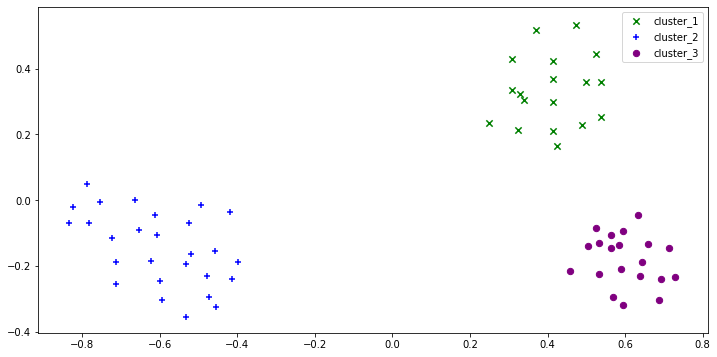

In [229]:
## visualization 
plt.figure(figsize=(12,6))
status_1 = np.where(belongs_to ==0)[0]
status_2 = np.where(belongs_to ==1)[0]
status_3 = np.where(belongs_to ==2)[0]
plt.scatter(three_globs[status_1,0],three_globs[status_1,1],  marker = 'x',color = 'green', s = 40,label = 'cluster_1')
plt.scatter(three_globs[status_2,0],three_globs[status_2,1],  marker = '+',color = 'blue', s = 40,label = 'cluster_2')
plt.scatter(three_globs[status_3,0],three_globs[status_3,1],  marker = 'o',color = 'purple', s = 40,label = 'cluster_3')
plt.legend(loc='upper right')

### Evaluate Performance

In [287]:
## converting the true labels
label_true = np.zeros([len(three_globs_df),1])

for i in range(len(three_globs_df.index)):
    if three_globs_df.index[i] == 'GLOB_1':
        label_true[i] = 1
    if three_globs_df.index[i] == 'GLOB_2':
        label_true[i] = 0
    if three_globs_df.index[i] == 'GLOB_3':
        label_true[i] = 2
        
label_pred = belongs_to

In [303]:
## evaluation using accuracy
accuracy_socre = accuracy(label_true, label_pred)

## evaluation using normalized_mutual_info_score
NMI_score = normalized_mutual_info_score(label_true, label_pred)

## evaluation using adjusted_rand_score
ARI_score = adjusted_rand_score(label_true, label_pred)

print('accuracy_socre is %f,' %accuracy_socre,\
      'normalized_mutual_info_score is %f,' %NMI_score,\
      'adjusted_rand_score is %f.' %ARI_score)

accuracy_socre is 1.000000, normalized_mutual_info_score is 1.000000, adjusted_rand_score is 1.000000.


From the result, we can see that, the three external measurements have the same results. And all of them is 1.0, which means the clustering is very good!

In [506]:
## run 10 times and do the recording
from time import *
times = np.zeros([10,1])
for i in range(10):
    begin_time = time()
    kmeans(k=3, epsilon=1.06, distance='euclidian', dataset= three_globs)
    end_time = time()
    run_time = end_time-begin_time
    times[i] = run_time

In [507]:
times

array([[1.56800747e-02],
       [6.89029694e-05],
       [8.18514824e-03],
       [5.38825989e-05],
       [3.83067131e-03],
       [4.28700447e-03],
       [4.82678413e-03],
       [8.24308395e-03],
       [5.73897362e-03],
       [5.14101982e-03]])

In [512]:
print('Average running time is %f' %np.mean(times))

Average running time is 0.005606


#### Hartigan KMeans

In [ ]:
from sklearn.cluster import KMeans
from numpy import array

def hartigan_K(list_of_tuples, threshold = 12):
    # 'list_of_tuples' is a list containing the points you want to cluster
    # 'threshold' optimizes goodness of fit values
    # returns integer, "correct" number of clusters
    
    inertia_list = zeros(len(list_of_tuples)+1) # initializes for maximum possible clusters
    num = 0                                     # counter
    H_Rule = threshold+1                        # simply initializes above threshold to meet 'while' condition
    
    # NOTE: 'inertia' is equivalent to the sum of within-cluster distances to centroids
    
    while num < len(list_of_tuples) and H_Rule > threshold:
        kmn = KMeans(n_clusters = num+1)
        kmn.fit(list_of_tuples)
        inertia_list[num+1]+=kmn.inertia_
        if num > 0:
            H_Rule = ((float(inertia_list[num])/inertia_list[num+1])-1)*(len(list_of_tuples)-(num)-1)
        num+=1
    
    if H_Rule > threshold:
        num+=1

    # (where N is the number of points under observation)
    
    return num-1

## Part III: DBSCAN(15 point）

### 1. Implementing DBSCAN

In [ ]:
# step 1: identify core points and its neighbors
# step 2: grow cluster
# step 3: label each points, -1 for noise

In [304]:
## loading data
anthill = pd.read_csv('/Users/tjmask/Desktop/Semester 2/Data Mining/HW1/hw1/Homework_1/Datasets/anthill.csv')
anthill_df = anthill
anthill = np.array(anthill)

In [305]:
################### Notes: only 38 lines and deserve 5 bonus points ##########################

## first we need to find the noise 
'''
there are two threshold to define a noise, the density and radius. Density can be 
thought as how many points does this point can have with given radius. When the distances
between the choosen point with other points are less than the given radius, then the other
points should be included in the choosen point's density. If the total number of included 
points are larger than or equal to the min number of points(threshold, hyperparameters),we say it's a 
core point. while the total number of included points are less than the min number of points, 
we can it broder points. And the others are noise, and should be removed while we are doing clustering.
'''
## get the distance between two points
def dist(p,q):
    return math.sqrt(np.power(p-q,2).sum())

## find if the distance is less than given radius
def neighborhood(p,q,radius):
    return dist(p,q) < radius

## find all neighbors of a point
def regionScan(dataset, P, radius):
    neighbors = []
    # For each point in the dataset...
    for x in range(0, len(dataset)):
        if neighborhood(dataset[P], dataset[x], radius):
            neighbors.append(x)
    return neighbors

def growCluster(dataset, labels, P, NeighborPts, C, radius, MinPts):

    # Assign the cluster label to the seed point.
    labels[P] = C
    
    i = 0
    while i < len(NeighborPts):    
        
        # Get the next point from the queue.        
        Pn = NeighborPts[i]
       
        # If Pn was labelled NOISE during the seed search, then we
        # know it's not a branch point (it doesn't have enough neighbors), so
        # make it a leaf point of cluster C and move on.
        if labels[Pn] == -1:
            labels[Pn] = C
        
        # Otherwise, if Pn isn't already claimed, claim it as part of C.
        elif labels[Pn] == 0:
            # Add Pn to cluster C (Assign cluster label C).
            labels[Pn] = C
            
            # Find all the neighbors of Pn
            PnNeighborPts = regionScan(dataset, Pn, radius)
             
            if len(PnNeighborPts) >= MinPts:
                NeighborPts = NeighborPts + PnNeighborPts
            else:               
                NeighborPts = NeighborPts               
        i += 1  
               
def DBSCAN(dataset, radius, MinPts):
    labels = [0]*len(dataset)    
    C = 0
    
    for P in range(0, len(dataset)):
        if not (labels[P] == 0):
            continue
        
        NeighborPts = regionScan(dataset, P, radius)
        if len(NeighborPts) < MinPts:
            labels[P] = -1    
        else: 
            C += 1
            growCluster(dataset, labels, P, NeighborPts, C, radius, MinPts)
    return labels      

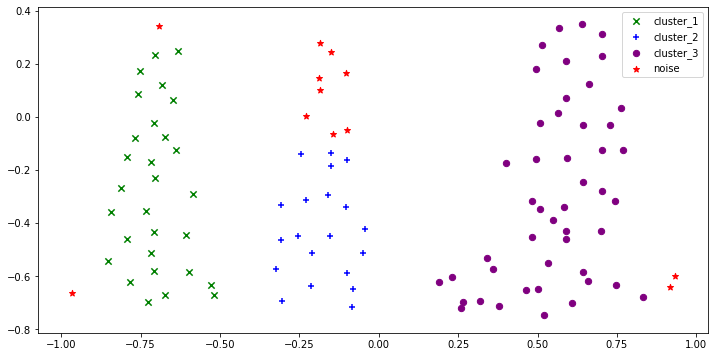

In [306]:
labels = DBSCAN(anthill, 0.2,10)
labels = np.array(labels)
data = anthill 
## visualiztion
plt.figure(figsize=(12,6))
plt.scatter(data[labels==1,0],data[labels==1,1],  marker = 'x',color = 'green', s = 40,label = 'cluster_1')
plt.scatter(data[labels==2,0],data[labels==2,1],  marker = '+',color = 'blue', s = 40,label = 'cluster_2')
plt.scatter(data[labels==3,0],data[labels==3,1],  marker = 'o',color = 'purple', s = 40,label = 'cluster_3')
plt.scatter(data[labels==-1,0],data[labels==-1,1],marker = '*',color = 'red', s = 40,label = 'noise')
plt.legend(loc='upper right')

### Evaluate Performance

In [332]:
## converting the true labels
dbscan_label_true = np.zeros(len(anthill_df))

for i in range(len(anthill_df.index)):
    if anthill_df.index[i] == 'LEFT':
        dbscan_label_true[i] = 1
    if anthill_df.index[i] == 'CENTER':
        dbscan_label_true[i] = 2
    if anthill_df.index[i] == 'RIGHT':
        dbscan_label_true[i] = 3
        
db_scan_label_pred = labels

In [335]:
dbscan_label_true,db_scan_label_pred

(array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 2., 2., 2.,
        2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
        2., 2., 2., 2., 2., 2., 2., 2., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
        3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
        3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
        3., 3., 3., 3., 3., 3.]),
 array([-1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  2,  2,  2,
         2,  2,  2, -1,  2,  2,  2, -1, -1, -1,  2,  2,  2,  2, -1, -1,  2,
        -1,  2, -1,  2,  2,  2,  2,  2,  3,  3,  3,  3,  3,  3,  3,  3,  3,
         3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
         3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
         3,  3,  3,  3, -1, -1]))

In [334]:
## evaluation using accuracy
accuracy_socre = accuracy(dbscan_label_true, db_scan_label_pred)

## evaluation using normalized_mutual_info_score
NMI_score = normalized_mutual_info_score(dbscan_label_true, db_scan_label_pred)

## evaluation using adjusted_rand_score
ARI_score = adjusted_rand_score(dbscan_label_true, db_scan_label_pred)

print('accuracy_socre is %f,' %accuracy_socre,\
      'normalized_mutual_info_score is %f,' %NMI_score,\
      'adjusted_rand_score is %f.' %ARI_score)

accuracy_socre is 0.453704, normalized_mutual_info_score is 0.829994, adjusted_rand_score is 0.863202.


From the result, we can see that, the normalized_mutual_info_score and adjusted_rand_score are very high, while accuracy_socre is not good. In this case, we might think that there should be some drawbacks of accuracy_socre. For example, it requires manual assignment by human annotators, which is kind of like supervised learning and inconsistent with what we are doing.

## Part IV: Spectral Clustering and Kernel K-means (15 point)

### Spectral Clustering

In [2]:
import pandas as pd
import numpy as np
import math
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform
from scipy.sparse.linalg.eigen.arpack import eigsh 
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [53]:
## loading data 
eye  = pd.read_csv('/Users/tjmask/Desktop/Semester 2/Data Mining/HW1/hw1/Homework_1/Datasets/eye.csv')
eye  = eye.rename(columns={'Unnamed: 0': 'label'})
data = np.array(eye)
data = data[:,1:]
data[:5]

array([[-0.78304, 0.2793],
       [-0.7530399999999999, 0.021],
       [-0.7581, -0.2394],
       [-0.75312, 0.20449],
       [-0.72319, -0.28928000000000004]], dtype=object)

In [54]:
## getting the similarity matrix
def get_simi_matrix(dataset, sigma=1):
    distance = np.power(pdist(dataset, 'euclidean'),2)
    
    ## getting the distance among points based Gussian distance
    def mapping(x):
        return math.exp(-x/sigma)
    return squareform(list(map(mapping,distance))) + np.eye(dataset.shape[0]) 

In [55]:
simi_matrix = get_simi_matrix(data, sigma = 0.05)
simi_matrix.shape

(180, 180)

In [56]:
# shape(180,)
Distance = sum(simi_matrix) 
Distance = np.power(Distance,-1/2)

# Laplician matrix
Lap_matrix = np.eye(len(Distance))-np.dot(np.dot(np.diag(Distance),simi_matrix),np.diag(Distance)) 
Lap_matrix.shape

(180, 180)

In [57]:
# Input number of clusters
num_clusters = 2 

# find the smallest eigenvectors
x, eigenv = eigsh(Lap_matrix, num_clusters, which='SM')

In [58]:
## using K-means
kmeans = KMeans(n_clusters=num_clusters, random_state=42).fit(eigenv)
labels = kmeans.labels_ 
labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1,
       0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0], dtype=int32)

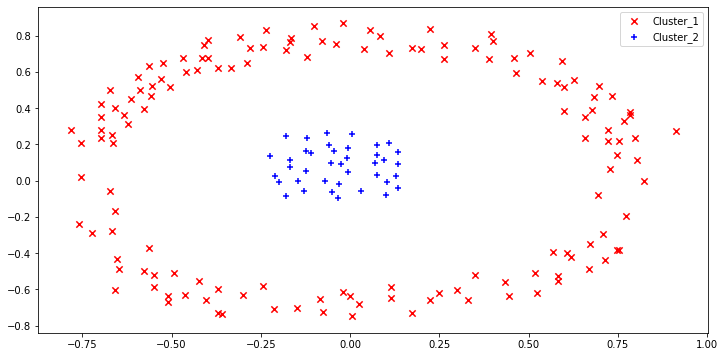

In [60]:
# Visualization
plt.figure(figsize=(12,6))
plt.scatter(data[labels==0,0],data[labels==0,1], marker = 'x',color = 'red', s = 40 ,label = 'Cluster_1')
plt.scatter(data[labels==1,0],data[labels==1,1], marker = '+', color = 'blue', s = 40, label = 'Cluster_2')
plt.legend()

### Evaluation

In [64]:
## getting predited and true labels 
spec_label_true = np.zeros(len(eye))

for i in range(len(eye['label'])):
    if eye['label'][i] == 'ORB':
        spec_label_true[i] = 0
    if eye['label'][i] == 'PUPIL':
        spec_label_true[i] = 1
        
spec_scan_label_pred = labels

In [78]:
## evaluation using accuracy
accuracy_socre = accuracy(spec_label_true, spec_scan_label_pred)

## evaluation using normalized_mutual_info_score
NMI_score = normalized_mutual_info_score(spec_label_true, spec_scan_label_pred)

## evaluation using adjusted_rand_score
ARI_score = adjusted_rand_score(spec_label_true, spec_scan_label_pred)

print('accuracy_socre is %f,' %accuracy_socre,\
      'normalized_mutual_info_score is %f,' %NMI_score,\
      'adjusted_rand_score is %f.' %ARI_score)

accuracy_socre is 1.000000, normalized_mutual_info_score is 1.000000, adjusted_rand_score is 1.000000.


From the result, we can see that, the three external measurements have the same results. And all of them is 1.0, which means the clustering is very good!

### Kernel K-means

In [90]:
from utils import * 
from math import exp 

In [123]:
def squaredDistance(a, b):
    return np.linalg.norm(a-b)

def kernel(dataset, sigma):
    """
    :param dataset: data points: arrary[[a,b],[c,d]....]
    :param sigma: Gaussian radial basis function
    """
    nData = len(dataset)
    Gram = np.zeros([len(dataset),len(dataset)])# nData x nData matrix
    # Calculate the Gram matrix

    # symmetric matrix
    for i in range(nData):
        for j in range(i,nData):
            if i != j: # diagonal element of matrix = 0
                # kernel: K(xi,xj) = e ( (-|xi-xj|**2) / (2sigma**2)
                square_dist = squaredDistance(data[i],data[j])
                base = 2.0 * sigma**2
                Gram[i][j] = exp(-square_dist/base)
                Gram[j][i] = Gram[i][j]
    return Gram 

In [124]:
distance = kernel(data, 0.04)
distance.shape

(180, 180)

In [129]:
# Suppose there are 2 clusters
K = 2  
centers = []
for i in range(K):
    centers.append(data[i])
results = KMeans(data, centers)
results = kmeans.labels_
results

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1,
       0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0], dtype=int32)

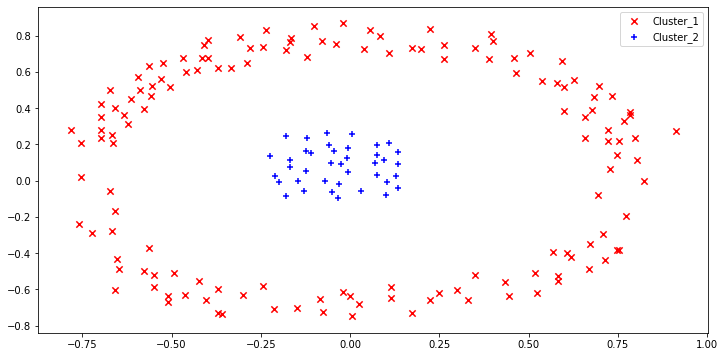

In [131]:
# Visualization
plt.figure(figsize=(12,6))
plt.scatter(data[results==0,0],data[results==0,1], marker = 'x',color = 'red', s = 40 ,label = 'Cluster_1')
plt.scatter(data[results==1,0],data[results==1,1], marker = '+', color = 'blue', s = 40, label = 'Cluster_2')
plt.legend()

### Evaluation

In [130]:
## evaluation using accuracy
accuracy_socre = accuracy(spec_label_true, results)

## evaluation using normalized_mutual_info_score
NMI_score = normalized_mutual_info_score(spec_label_true, results)

## evaluation using adjusted_rand_score
ARI_score = adjusted_rand_score(spec_label_true, results)

print('accuracy_socre is %f,' %accuracy_socre,\
      'normalized_mutual_info_score is %f,' %NMI_score,\
      'adjusted_rand_score is %f.' %ARI_score)

accuracy_socre is 1.000000, normalized_mutual_info_score is 1.000000, adjusted_rand_score is 1.000000.


We can see that both Spectral Clustering and Kernel K-means are very similar. The difference is that Spectral Clustering need to get elgen vector. However, normalized Spectral Clustering and weighted Kernel K-means are the same.